# TUTORIAL 2 - Text Mining
* Text Retrieval and Mining, BSc BAN Y3, 2023-2024
* Author: [Julien Rossi](mailto:j.rossi@uva.nl)

# Hint

* Say you have a pandas DataFrame with columns "year" / "article"
* You record 1 row each time you sell an article
* How to get the TOP-2 of sold articles per year ?


* Have a look at this code
* It goes step by step through the process

In [ ]:
# Build an example dataframe randomly
years = [2020, 2021, 2021, 2022]
articles = ["key"] + ["pen"] + ["cheese"] * 4 + ["potatoes"]

import random
random.seed(42)
data = [{"year": random.choice(years), "article": random.choice(articles)} for _ in range(10000)]

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data)
df.head()

,year,article
0,2020,key
1,2021,pen
2,2021,pen
3,2020,cheese
4,2020,cheese


In [ ]:
df.groupby(["year", "article"]).size()

year  article 
2020  cheese      1415
      key          352
      pen          347
      potatoes     354
2021  cheese      2828
      key          696
      pen          716
      potatoes     725
2022  cheese      1461
      key          395
      pen          366
      potatoes     345
dtype: int64

In [ ]:
df.groupby(["year", "article"]).size().reset_index(name="count")

,year,article,count
0,2020,cheese,1415
1,2020,key,352
2,2020,pen,347
3,2020,potatoes,354
4,2021,cheese,2828
5,2021,key,696
6,2021,pen,716
7,2021,potatoes,725
8,2022,cheese,1461
9,2022,key,395


In [ ]:
df.groupby(["year", "article"]).size().reset_index(name="count").sort_values(by=["year", "count"], ascending=[True, False])

,year,article,count
0,2020,cheese,1415
3,2020,potatoes,354
1,2020,key,352
2,2020,pen,347
4,2021,cheese,2828
7,2021,potatoes,725
6,2021,pen,716
5,2021,key,696
8,2022,cheese,1461
9,2022,key,395


In [ ]:
grp = df.groupby(["year", "article"]).size().reset_index(name="count").sort_values(by=["year", "count"], ascending=[True, False])

In [ ]:
grp.groupby("year").head(2)

,year,article,count
0,2020,cheese,1415
3,2020,potatoes,354
4,2021,cheese,2828
7,2021,potatoes,725
8,2022,cheese,1461
9,2022,key,395


In [ ]:
grp.groupby("year").head(2).set_index(["year", "article"])

count
year article        
2020 cheese     1415
     potatoes    354
2021 cheese     2828
     potatoes    725
2022 cheese     1461
     key         395

# PACKAGE INSTALLS

In [ ]:
!pip install spacy-entity-linker

  Preparing metadata (setup.py) ... done
  Created wheel for spacy-entity-linker: filename=spacy_entity_linker-1.0.3-py3-none-any.whl size=14375 sha256=b75d8531ed6904fd024bb4443725302cccaf2e3cc1417ba8b28a49231ad63bc4
  Stored in directory: /root/.cache/pip/wheels/6d/73/f9/568b5f541ed2d6f9adb8556b8ef9995e5528f3f9ab2b83b196
Successfully built spacy-entity-linker


# Data Preparation

We will use the News Articles dataset.

See [Link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/GMFCTR).

This dataset was made for studying political bias in articles, and is made of articles from different sources, reporting on political topics.



## Downloads

In [ ]:
import requests

In [ ]:
# Downloads the articles

r = requests.get("https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/GMFCTR/IZQODZ")
assert r.status_code == 200
with open("NewsArticles.csv", "wb") as out:
    out.write(r.content)

In [ ]:
# Downloads the documents preprocessed by SpaCy (for speed)

r = requests.get("https://surfdrive.surf.nl/files/index.php/s/dMG8AbWWcUpiq4a/download")
assert r.status_code == 200
with open("docs.spacy", "wb") as out:
    out.write(r.content)

In [ ]:
import pandas as pd

df = pd.read_csv('NewsArticles.csv', encoding='latin1')
df = df[['publish_date', 'text']].copy().dropna().reset_index(drop=True)
df["publish_date"] = pd.to_datetime(df["publish_date"])
print(df.shape)

(3791, 2)


In [ ]:
df.head()

,publish_date,text
0,2017-02-07,Michigan billionaire education activist Betsy ...
1,2017-02-07,First lady Melania Trump has said little about...
2,2017-02-07,A House committee voted on Tuesday to eliminat...
3,2017-02-07,"This afternoon, three federal judges from the ..."
4,2017-02-07,At least four tornadoes touched down in Louisi...


In [ ]:
import spacy
from spacy.tokens import DocBin

en = spacy.load("en_core_web_sm")
doc_bin = DocBin().from_disk("docs.spacy")
df["spacy_doc"] = list(doc_bin.get_docs(vocab=en.vocab))

## Statistics

In [ ]:
df.groupby(df["publish_date"].dt.year).size()

publish_date
2016     131
2017    3660
dtype: int64

In [ ]:
df["nb_words"] = df["spacy_doc"].apply(len)

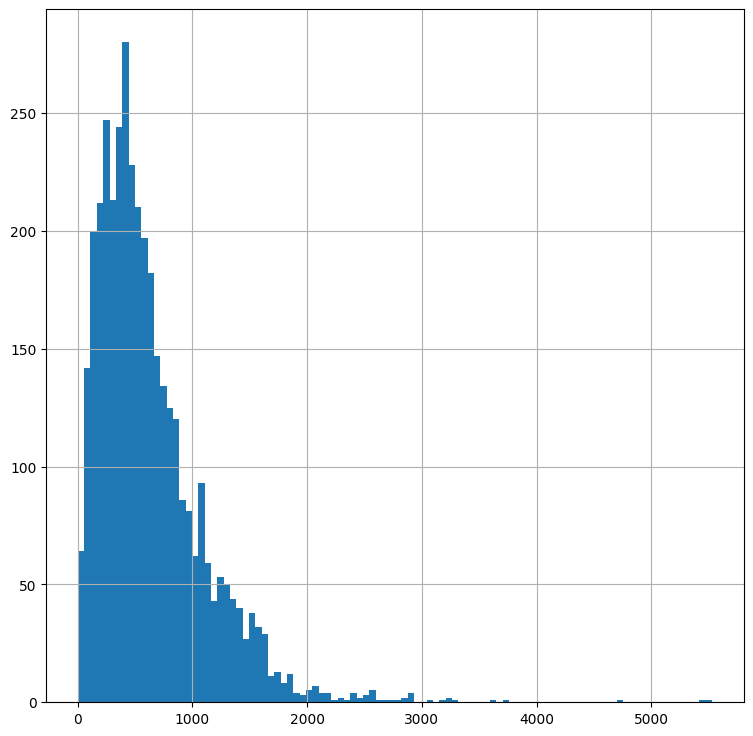

In [ ]:
_ = df['nb_words'].hist(bins=100, figsize=(9, 9))

# Text Mining

* We will search for different aspects of the text
* nouns, adverbs, etc...

# Exercise 1

**INSTRUCTIONS**
* Use the lowercase lemmatized version of the word
* with SpaCy `Token`, the lemma of a token is the attribute `lemma_`
* Build a dataframe with columns `"pos", "lemma"`
  * Go over each token of each document
  * For each token, add a row to the dataframe with `pos = the POS tag of the token`, and `lemma = the lowercase LEMMA of the token`
  * Total number of tokens: `2393052`

**QUESTION**
* What are the TOP-3 most frequent VERBs over the corpus ?
* Same for Nouns ?
* Same fo Pronouns ?
* How many different POS tags were given to `"make"`


In [ ]:
from collections import defaultdict

pos = []

for doc in df["spacy_doc"]:
    for token in doc:
        pos.append({"pos": token.pos_, "lemma": token.lemma_.lower()})

In [ ]:
pos_df = pd.DataFrame(pos)

In [ ]:
pos_df.shape

(2393052, 2)

In [ ]:
pos_df.head()

,pos,lemma
0,PROPN,michigan
1,NOUN,billionaire
2,NOUN,education
3,NOUN,activist
4,PROPN,betsy


In [ ]:
pos_df["pos"].value_counts()

NOUN     443415
PUNCT    290784
VERB     257371
ADP      253286
PROPN    249005
DET      201842
ADJ      158922
PRON     126640
AUX      115367
ADV       73154
PART      68039
CCONJ     62581
NUM       44236
SCONJ     39756
SYM        3049
SPACE      2869
X          1837
INTJ        899
Name: pos, dtype: int64

In [ ]:
pos_df[pos_df["pos"] == "VERB"]["lemma"].value_counts().head(3)

say     19393
have     6955
make     4142
Name: lemma, dtype: int64

In [ ]:
pos_df[pos_df["pos"] == "NOUN"]["lemma"].value_counts().head(3)

year       6373
people     4709
country    3997
Name: lemma, dtype: int64

In [ ]:
pos_df[pos_df["pos"] == "PRON"]["lemma"].value_counts().head(3)

it      14704
he      14338
they     8940
Name: lemma, dtype: int64

In [ ]:
pos_df[pos_df["lemma"] == "make"]["pos"].value_counts()

VERB     4142
NOUN        9
PROPN       3
Name: pos, dtype: int64

# Exercise 2

**INSTRUCTIONS**
* Use the lowercase lemmatized version of the word
* with SpaCy `Token`, the lemma of a token is the attribute `lemma_`
* Build a dataframe with columns `"pronoun", "verb"`
  * Go over each token of each document
  * Identify all the tokens that match these criteria:
    * their POS tag corresponds to pronouns
    * they are one of `["i", "you", "he", "she", "we", "you", "they"]`
    * they are the subject of a verb
  * Add a row with `"pronoun" = the pronoun, "verb" = the lowercase lemma of the verb`
  * Total number of rows: `33256`

**QUESTION**
* Show the frequency of each pronoun, each verb
* Show for each pronoun the TOP 5 verbs of which it is a subject

**QUESTION (extra)**
* What is the most frequent adverb that modifies `"say"` ?


In [ ]:
subj = []

for doc in df["spacy_doc"]:
    for token in doc:
        if token.pos_ == "PRON" and token.text.lower() in {"i", "you", "he", "she", "we", "you", "they"} and token.dep_ == "nsubj" and token.head.pos_ == "VERB":
            subj.append({"pronoun": token.text.lower(), "verb": token.head.lemma_.lower()})

In [ ]:
subj_df = pd.DataFrame(subj)

In [ ]:
subj_df.head()

,pronoun,verb
0,she,read
1,she,attend
2,she,hedge
3,they,support
4,she,appreciate


In [ ]:
subj_df.shape

(33256, 2)

In [ ]:
subj_df["pronoun"].value_counts()

he      10365
we       6205
i        5635
they     5072
she      3125
you      2854
Name: pronoun, dtype: int64

In [ ]:
subj_df["verb"].value_counts()

say               3790
have              2444
think             1173
want              1149
know               814
                  ... 
fry                  1
scope                1
overhear             1
hungry?"?after       1
instance             1
Name: verb, Length: 1583, dtype: int64

In [ ]:
grps = subj_df.groupby(["pronoun", "verb"]).size().reset_index(name="count").sort_values(by=["pronoun", "count"], ascending=[True, False])

In [ ]:
grps.groupby("pronoun").head(5).set_index(["pronoun", "verb"])

count
pronoun verb        
he      say     2543
        have     396
        add      392
        tell     281
        want     169
i       think    828
        have     362
        know     275
        want     258
        see      182
she     say      788
        have     123
        tell     111
        add       96
        want      59
they    have     368
        say      182
        want     174
        do       139
        get      114
we      have     783
        see      266
        want     253
        need     244
        do       216
you     have     412
        want     236
        know     169
        see      121
        need     115

In [ ]:
advs = []

for doc in df["spacy_doc"]:
    for token in doc:
        if token.pos_ == "ADV" and token.dep_ == "advmod" and token.head.lemma_.lower() == "say":
            advs.append(token.lemma_.lower())

In [ ]:
from collections import Counter

dic = Counter(advs)
dic.most_common(n=3)

[('also', 286), ('however', 107), ('early', 62)]

# Exercise 3


**QUESTION**
* What was the most frequent entity per month and per entity category ?
* What was the TOP-5 Geopolitical entities (`GPE`) ?

In [ ]:
df["month-year"] = df["publish_date"].dt.strftime("%Y-%m")

ents = []

for _, row in df.iterrows():
    for ent in row["spacy_doc"].ents:
        ents.append({"label": ent.label_, "entity": ent.text.lower(), "month": row["month-year"]})

In [ ]:
ents_df = pd.DataFrame(ents)

In [ ]:
ents_df.head()

,label,entity,month
0,GPE,michigan,2017-02
1,PERSON,betsy devos,2017-02
2,DATE,today,2017-02
3,PERSON,trump,2017-02
4,PERSON,mike pence,2017-02


In [ ]:
grps = ents_df.groupby(["month", "label", "entity"]).size().reset_index(name="count").sort_values(by=["month", "label", "count"], ascending=[True, True, False])

In [ ]:
pd.set_option('display.max_rows', 100)
grps.groupby(["month", "label"]).first()

entity  count
month   label                                               
2016-04 CARDINAL                            about 100      2
        DATE                                last year      3
        GPE                                     china     11
        MONEY                                   3,000      1
        NORP                                  chinese      9
        ORDINAL                                 first      4
        ORG                               project vic      3
        PERCENT                                   94%      1
        PERSON                                 nguyen      6
        PRODUCT                                  cole      9
        TIME                               four hours      1
        WORK_OF_ART                         photo dna      1
2016-08 CARDINAL                                  one      2
        DATE                                    years      2
        GPE                                  manitoba      8
        LOC                                  winnipeg      3
        MONEY               between $1,000 and $2,000      1
        NORP                                 canadian      2
        ORDINAL                                 first      1
        ORG          the cnn freedom project canada's      1
        PERCENT                               just 4%      1
        PERSON                                 chopek      5
2016-12 CARDINAL                                  one    112
        DATE                                     2017     56
        EVENT                            world war ii      4
        FAC                         the belt and road     13
        GPE                                     china    833
        LANGUAGE                              chinese      6
        LAW                                article 15      4
        LOC                                    europe    109
        MONEY                             $10 billion      3
        NORP                                  chinese    569
        ORDINAL                                 first    118
        ORG               china daily european weekly     79
        PERCENT                            10 percent      5
        PERSON                           harry potter     34
        PRODUCT                                   cao      7
        QUANTITY                    100 square meters      2
        TIME                                 24 hours      3
        WORK_OF_ART                              emba      2
2017-01 CARDINAL                                  one    136
        DATE                                     2016    108
        EVENT                         spring festival     24
        FAC                  belt and road initiative      5
        GPE                                     china   1034
        LANGUAGE                              english     25
        LAW                      the clean power plan      4
        LOC                                    europe     74
        MONEY                            $1.6 billion      3
        NORP                                  chinese    695
        ORDINAL                                 first    163
        ORG                                     trump     71
        PERCENT                            10 percent      8
        PERSON                                     xi     56
        PRODUCT                                   cao      3
        QUANTITY                          10,000 tons      2
        TIME                                    night      4
        WORK_OF_ART                              love      3
2017-02 CARDINAL                                  one    832
        DATE                                 thursday    386
        EVENT                               world cup     22
        FAC                           the white house     45
        GPE                                        us   1063
        LANGUAGE                              english     27
        LAW          

In [ ]:
grps = ents_df[ents_df["label"] == "GPE"][["month", "entity"]].groupby(["month", "entity"]).size().reset_index(name="count").sort_values(by=["month", "count"], ascending=[True, False])

In [ ]:
grps.groupby("month").head(5).set_index(["month", "entity"])

count
month   entity                  
2016-04 china                 11
        vietnam                7
        the united states      2
        australia              1
        canada                 1
2016-08 manitoba               8
        canada                 5
        little                 1
2016-12 china                833
        us                   131
        beijing              105
        shanghai              91
        uk                    57
2017-01 china               1034
        us                   223
        beijing              146
        uk                   127
        shanghai              67
2017-02 us                  1063
        russia               935
        china                430
        germany              370
        syria                358
2017-03 us                  1763
        russia              1073
        china                770
        uk                   579
        syria                481

# Exercise 4

**INSTRUCTION**
* Run the SpaCy entity linker on the articles from 2016
* Identify all linked entities which are an instance of "city" (their ID belongs to the list of cities in Wikidata)
* Except those whose label is `capital`

**QUESTION**
* What are the top-10 most frequent cities in 2016 ?

In [ ]:
# Given code, get the list of cities in Wikidata
# It is a list of entity ID (integer)

from spacy_entity_linker.DatabaseConnection import get_wikidata_instance

wikidata = get_wikidata_instance()
cities: list[int] = set(wikidata.get_instances_of(515))

In [ ]:
en.add_pipe("entityLinker", last=True)

In [ ]:
df_2016 = df["publish_date"].dt.year == 2016
df.loc[df_2016, "linked_ents_doc"] = df[df_2016]["text"].apply(en)

In [ ]:
df[df_2016].shape

(131, 6)

In [ ]:
data = []

for doc in df[df_2016]["linked_ents_doc"]:
    for ent in doc._.linkedEntities:
        if ent.get_id() in cities and ent.get_label() != "capital":
            data.append(ent.get_label())

In [ ]:
dic = Counter(data)
dic.most_common(10)

[('Beijing', 105),
 ('Shanghai', 94),
 ('London', 43),
 ('Hong Kong', 35),
 ('Shenzhen', 16),
 ('Guangzhou', 13),
 ('Chengdu', 13),
 ('Singapore', 10),
 ('New York City', 9),
 ('Paris', 8)]